# Metadata

```
Course:   DS 5001
Module:   03 Lab
Topic:    Inferring Language Models
Author:   R.C. Alvarado

Purpose:  We create word-level langage models using simple smoothing from a set of novel. We then evaluate them as predictors of variosu sentences and as generators of text (as in the Shannon Game).
```

# Set Up

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

In [2]:
# This prevents matplotlib from throw irrelevant errors
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [3]:
sns.set()

## Configure

In [4]:
data_home = '../data'

In [5]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
text_file = f'{data_home}/output/austen-combo.csv' # Generated in HW 02

In [6]:
ngram_size = 3
k = .5 # Add-k Smoothing parameter

# Get Training Data

## Import TOKENS

We use our way of representing a text as input. Normally, `term_str` would already be included in the dataframe.

In [7]:
TOKENS = pd.read_csv(text_file).set_index(OHCO).dropna()
TOKENS['term_str'] = TOKENS.token_str.str.lower().str.replace(r'[\W_]+', '', regex=True)
TOKENS = TOKENS[TOKENS.term_str != '']

In [8]:
TOKENS.head()

token_str  term_str
book_id chap_num para_num sent_num token_num                    
1       1        1        0        0               The       the
                                   1            family    family
                                   2                of        of
                                   3          Dashwood  dashwood
                                   4               had       had

# Handle OOV Terms

## Extract VOCAB

In [9]:
VOCAB = TOKENS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()

In [10]:
VOCAB.head()

,n,n_chars
term_str,,
1,3,1
15,1,2
16,1,2
1760,1,4
1784,1,4


## Compute HAPAX info

We use hapax info to account for out-of-vocabulary (OOV) terms in our test data. Hapax refers to *hapax legomenon*, meaning a word that appears only once in a corpus. Normally, with a large training corpus, we might just replace all hapax terms with `<UNK>`. But our set is small, so we try something else. We use the probability features of terms based on length to locate these. This prevents us from getting rid of "good" words that appear in low frequency.

In [11]:
HAPAX = VOCAB.query("n == 1").n_chars.value_counts().to_frame('n').sort_index() 
HAPAX.index.name = 'n_chars'
HAPAX['p'] = HAPAX.n / HAPAX.n.sum()
HAPAX['i'] = np.log2(1/HAPAX.p)

In [12]:
HAPAX.style.background_gradient()

,n,p,i
n_chars,,,
1,6,0.001935,9.013555
2,8,0.002580,8.598518
3,35,0.011287,6.469235
4,152,0.049016,4.350590
5,294,0.094808,3.398845
6,397,0.128023,2.965523
7,477,0.153821,2.700672
8,478,0.154144,2.697651
9,451,0.145437,2.781534


In [13]:
hapax_mean = HAPAX.i.mean() # Use mean as threshhold

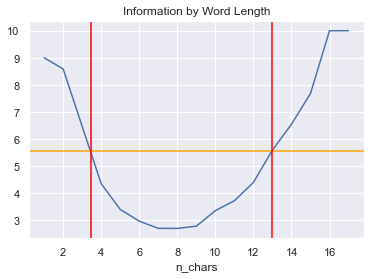

In [14]:
HAPAX.i.plot(title="Information by Word Length");
plt.axhline(y=hapax_mean, color='orange')
plt.axvline(x=3.45, color='red')
plt.axvline(x=13, color='red');

In [15]:
unk_list_i = HAPAX[HAPAX.i > hapax_mean].index.to_list()
UNK = VOCAB[VOCAB.n_chars.isin(unk_list_i) & (VOCAB.n == 1)].index.to_list()        

In [16]:
unk_list_i

[1, 2, 3, 13, 14, 15, 16, 17]

In [17]:
HTML(' '.join(UNK))

## Create Training VOCAB $V_{train}$

In [18]:
V_TRAIN = sorted(list(set(VOCAB.index) - set(UNK))  + ['<UNK>'])

In [19]:
V_TRAIN[100:105]

['aches', 'aching', 'acknowledge', 'acknowledged', 'acknowledgement']

## Generate Training Sentences

In [20]:
S_TRAIN = list(TOKENS.groupby(OHCO[:-1]).term_str.apply(lambda x: ' '.join(x)).values)

In [21]:
S_TRAIN[:5]

['the family of dashwood had long been settled in sussex',
 'their estate was large and their residence was at norland park in the centre of their property where for many generations they had lived in so respectable a manner as to engage the general good opinion of their surrounding acquaintance',
 'the late owner of this estate was a single man who lived to a very advanced age and who for many years of his life had a constant companion and housekeeper in his sister',
 'but her death which happened ten years before his own produced a great alteration in his home',
 'for to supply her loss he invited and received into his house the family of his nephew mr']

# Interlude: Demonstrate Logic

## Pad Sentences and Generate New Tokens 

In [22]:
S = pd.DataFrame(dict(sent_str=S_TRAIN))
pad = '<s> ' * (ngram_size - 1)
S['padded'] = pad + S.sent_str + ' ' + ' </s>'
I = S.padded.str.split(expand=True).stack().to_frame('w0')
I.index.names = ['sent_num', 'token_num']
S['len'] = I.groupby('sent_num').w0.count()

In [23]:
S.head()

,sent_str,padded,len
0,the family of dashwood had long been settled i...,<s> <s> the family of dashwood had long been s...,13
1,their estate was large and their residence was...,<s> <s> their estate was large and their resid...,43
2,the late owner of this estate was a single man...,<s> <s> the late owner of this estate was a si...,37
3,but her death which happened ten years before ...,<s> <s> but her death which happened ten years...,20
4,for to supply her loss he invited and received...,<s> <s> for to supply her loss he invited and ...,21


In [24]:
I.head()

w0
sent_num token_num        
0        0             <s>
         1             <s>
         2             the
         3          family
         4              of

## Remove OOV terms from Tokens

In [25]:
I.loc[~I.w0.isin(V_TRAIN + ['<s>','</s>']), 'w0'] = '<UNK>'

In [26]:
I.query("w0 == '<UNK>'")

,,w0
sent_num,token_num,
114,17,<UNK>
188,14,<UNK>
263,34,<UNK>
324,28,<UNK>
467,42,<UNK>
...,...,...
13459,9,<UNK>
13479,17,<UNK>
13523,9,<UNK>


## Generate Ngram Index

We expand our padded token table with itself, offset by 1 each time.

Note: there are many ways to do this. We could use explicit joins, for example, using the OCHO as 
the key for the join. This would create ngrams that do not cross sentence boundaries, even
without the sentence boundary markers. 

In [27]:
for i in range(1, ngram_size):
    I[f'w{i}'] = I[f"w{i-1}"].shift(-1)   

In [28]:
I

w0        w1        w2
sent_num token_num                                
0        0                 <s>       <s>       the
         1                 <s>       the    family
         2                 the    family        of
         3              family        of  dashwood
         4                  of  dashwood       had
...                        ...       ...       ...
13624    9          persuasion        by      jane
         10                 by      jane    austen
         11               jane    austen      </s>
         12             austen      </s>       NaN
         13               </s>       NaN       NaN

[245679 rows x 3 columns]

In [29]:
I = I.dropna()

In [30]:
I.loc[0]

,w0,w1,w2
token_num,,,
0,<s>,<s>,the
1,<s>,the,family
2,the,family,of
3,family,of,dashwood
4,of,dashwood,had
5,dashwood,had,long
6,had,long,been
7,long,been,settled
8,been,settled,in


Also, arguably, there should be no lines in which `<s>` appears in the far right position. 
However, it turns out these are necessary to perform joins between the higher and lower order 
ngrams (i.e. when computing Smoothing Probabilities). They also help in the generation
of sentences from the model.

## Generate Lower Order Ngrams

We get column slices from I based on ngram level.

In [31]:
NG = []
for i in range(ngram_size):
    NG.append(I.iloc[:, :i+1].copy())

In [32]:
NG[0].loc[0]

,w0
token_num,
0,<s>
1,<s>
2,the
3,family
4,of
5,dashwood
6,had
7,long
8,been


## Extract Ngram Types and Frequencies

In [66]:
LM = []
for i in range(ngram_size):
    LM.append(NG[i].value_counts().to_frame('n'))
    LM[i] = LM[i].sort_index()

In [34]:
# Hack to recast single value tuple in unigram table index ...
LM[0].index = [i[0] for i in LM[0].index]
LM[0].index.name = 'w0'

In [35]:
LM[2].sort_values('n', ascending=False).head(10)

n
w0   w1   w2        
</s> <s>  <s>  13624
<s>  <s>  and   1440
          i     1044
          but    941
          she    706
          he     577
mrs  </s> <s>    530
<s>  <s>  the    515
          it     444
it   </s> <s>    367

## Apply Smoothing

* $c$: Individual ngram count.
* $k$: Liddstone smoothing value.
* $N$: Total ngram token count.
* $B$: Ngram type count; $ = V^{n}$ for ngram size $n$ and unigram vector length $V$.
* Seen ngram: $ \frac{c + k}{N + Bk} $
* Unseen ngram with seen context: $ \frac{k}{N + Bk} $
* Unseen ngram with unseen context: $ \frac{k}{Bk} \rightarrow \frac{1}{B} $
* Unknown Unigrams: `<UNK>`

In [36]:
# Z1 and Z2 will hold info about unseen ngrams
Z1 = [None for _ in range(ngram_size)] # Unseen N grams, but seen N-1 grams
Z2 = [None for _ in range(ngram_size)] # Unsess N-1 grams too
        
# The number of unigram types
V = len(LM[0]) # Inlcides <s> and </s>

In [37]:
# Sample space of possible ngram terms 
B = [V**(i+1) for i in range(ngram_size)]

# Ungram case
LM[0]['p'] = LM[0].n / LM[0].n.sum()
LM[0]['log_p'] = np.log2(LM[0].p)

# Higher-order cases
for i in range(1, ngram_size):      
    
    # We take advantage of Pandas' implicit join of the lower order
    # ngram table with the higher order on
    LM[i]['mle'] = LM[i].n / LM[i-1].n # The unsmoothed value
    LM[i]['p'] = (LM[i].n + k) / (LM[i-1].n + B[i-1] * k)
    LM[i]['log_p'] = np.log2(LM[i].p)
    
    # Handle unseen data
    Z1[i] = np.log2(k / (LM[i-1].n + B[i-1] * k))
    Z2[i] = np.log2(k / B[i-1] * k)
        
    # Just in case
    LM[i].sort_index(inplace=True)

In [38]:
LM[2].loc[('he','had')].sort_values('log_p', ascending=False).head(10)

,n,mle,p,log_p
w2,,,,
been,50,0.166113,1.550083e-06,-19.299223
not,20,0.066445,6.292418e-07,-20.599882
no,12,0.039867,3.836840e-07,-21.313578
a,8,0.026578,2.609051e-07,-21.869971
just,7,0.023256,2.302104e-07,-22.050544
never,6,0.019934,1.995157e-07,-22.256995
done,6,0.019934,1.995157e-07,-22.256995
seen,6,0.019934,1.995157e-07,-22.256995
the,6,0.019934,1.995157e-07,-22.256995


# Train Models

We now create a class to do the work of the preceding Interlude. 

## Generate and Count Ngrams

In [39]:
class NgramCounter():
    """A class to generate tables of ngram tokens and types from a list of sentences."""
    
    unk_sign = '<UNK>'
    sent_pad_signs = ['<s>','</s>']
        
    def __init__(self, sents:[], vocab:[], n:int=3):
        self.sents = sents # Expected to be normalized
        self.vocab = vocab # Can be extracted from another corpus
        self.n = n
        self.widx = [f'w{i}' for i in range(self.n)] # Used for cols and index names
        
    def generate(self):
        
        # Convert sentence list to dataframe
        self.S = pd.DataFrame(dict(sent_str=self.sents))
            
        # Pad sentences and create a new token table
        # Wrap sentences in <s> and </s> tags. Multiply <s> tags
        # as a function of ngram size, e.g. '<s> <s>' for trigrams.
        pad = (self.sent_pad_signs[0] + ' ') * (self.n - 1)
        self.I = (pad + self.S.sent_str + ' ' + self.sent_pad_signs[1])\
            .str.split(expand=True).stack().to_frame('w0')
        
        # Set index names to resulting token table
        self.I.index.names = ['sent_num', 'token_num']
        
        # Remove OOV terms
        # When processing test data, we use the training vocab
        # Anything that is not in the vocab (incl. s tags) is called <UNK>.
        self.I.loc[~self.I.w0.isin(self.vocab + self.sent_pad_signs), 'w0'] = self.unk_sign

        # Get sentence lengths (these will include pads)
        # May want to use this info when computing perplexity
        self.S['len'] = self.I.groupby('sent_num').w0.count()
                
        # Add w columns
        # We progressively bind columns of the same token sequence,
        # but offset by one each time
        for i in range(1, self.n):
            self.I[f'w{i}'] = self.I[f"w{i-1}"].shift(-1)         
        
        # Generate ngrams
        # We create ngram tables of all orders <= n by 
        # slicing off columns from the main table
        self.NG = []
        for i in range(self.n):
            self.NG.append(self.I.iloc[:, :i+1].copy())
            self.NG[i] = self.NG[i].dropna()
                                
        # Generate raw ngram counts and MLEs
        self.LM = []
        for i in range(self.n):
            self.LM.append(self.NG[i].value_counts().to_frame('n'))
            self.LM[i]['mle'] = self.LM[i].n / self.LM[i].n.sum()
            self.LM[i] = self.LM[i].sort_index()

        # Hack to remove single value tuple from unigram table ...
        self.LM[0].index = [i[0] for i in self.LM[0].index]
        self.LM[0].index.name = 'w0'

In [40]:
train = NgramCounter(S_TRAIN, V_TRAIN)
train.generate()

In [41]:
train.LM[1].sort_values('n', ascending=False).head()

n       mle
w0   w1                  
<s>  <s>  13625  0.055459
</s> <s>  13624  0.055455
<s>  and   1440  0.005861
     i     1044  0.004249
     but    941  0.003830

## Inspect how a sentence is represented

In [42]:
train.NG[0].loc[0]

,w0
token_num,
0,<s>
1,<s>
2,the
3,family
4,of
5,dashwood
6,had
7,long
8,been


In [43]:
train.NG[1].loc[0]

,w0,w1
token_num,,
0,<s>,<s>
1,<s>,the
2,the,family
3,family,of
4,of,dashwood
5,dashwood,had
6,had,long
7,long,been
8,been,settled


In [44]:
train.NG[2].loc[0]

,w0,w1,w2
token_num,,,
0,<s>,<s>,the
1,<s>,the,family
2,the,family,of
3,family,of,dashwood
4,of,dashwood,had
5,dashwood,had,long
6,had,long,been
7,long,been,settled
8,been,settled,in


## Estimate Model

In [45]:
class NgramLanguageModel():
    """A class to create ngram language models."""
    
    # Set the Lidstone Smoothing value; LaPlace = 1
    k:float = .5
    
    def __init__(self, ngc:NgramCounter):
        self.S = ngc.S
        self.LM = ngc.LM
        self.NG = ngc.NG
        self.n = ngc.n
        self.widx = ngc.widx
        
    def apply_smoothing(self):
        """Applies simple smoothing to ngram type counts to estimate the models."""
        
        # Z1 and Z2 will hold info about unseen ngrams
        self.Z1 = [None for _ in range(self.n)] # Unseen N grams, but seen N-1 grams
        self.Z2 = [None for _ in range(self.n)] # Unseen N-1 grams too
        
        # The base vocab size (same as number of unigram types)
        V = len(self.LM[0]) # Inlcides <s> and </s>
        
        # The number of ngram types
        B = [V**(i+1) for i in range(self.n)]

        # Handle unigram case (no need for smoothing)
        self.LM[0]['p'] = self.LM[0].n / self.LM[0].n.sum()
        self.LM[0]['log_p'] = np.log2(self.LM[0].p)

        # Handle higher order ngrams
        for i in range(1, self.n):      

            self.LM[i]['mle2'] = self.LM[i].n / self.LM[i-1].n
            self.LM[i]['p'] = (self.LM[i].n + self.k) / (self.LM[i-1].n + B[i-1] * self.k)
            self.LM[i]['log_p'] = np.log2(self.LM[i].p)

            # Unseen N grams, but seen N-1 grams
            self.Z1[i] = np.log2(self.k / (self.LM[i-1].n + B[i-1] * self.k))

            # Unsess N-1 grams too
            self.Z2[i] = np.log2(self.k / B[i-1] * self.k)
                
            self.LM[i].sort_index(inplace=True)

    def predict(self, test:NgramCounter):
        """Predicts test sentences with estimated models."""
        self.T = test
        self.PP = []
        p_key = 'log_p'
        for i in range(self.n):
            ng = i + 1
            if i == 0:
                self.T.S[f'ng_{ng}_ll'] = self.T.NG[0].join(self.LM[0].log_p, on=self.widx[:ng])\
                    .groupby('sent_num').log_p.sum()
            else:
                self.T.S[f'ng_{ng}_ll'] = self.T.NG[i].join(self.LM[i][p_key], on=self.widx[:ng])\
                    .fillna(self.Z1[i]).fillna(self.Z2[i])\
                    .groupby('sent_num')[p_key].sum()
                
            self.T.S[f'pp{ng}'] = 2**( -self.T.S[f'ng_{ng}_ll'] / self.T.S['len'])
                

In [46]:
model = NgramLanguageModel(train)
model.k = 1
model.apply_smoothing()

In [47]:
NG = model.NG
LM = model.LM
Z1 = model.Z1
Z2 = model.Z2

In [48]:
LM[2].loc[('anne', 'had')].sort_values('p', ascending=False)[['log_p']]

,log_p
w2,
not,-23.150067
never,-23.635494
been,-23.957422
a,-24.372459
the,-24.372459
no,-24.372459
always,-24.372459
left,-24.957422
to,-24.957422


In [49]:
LM[2].loc[('wentworth', 'had')].sort_values('p', ascending=False)[['n']]

,n
w2,
been,2
commanded,1
done,1
given,1
no,1
not,1
used,1


# Test Models

## Choose Test Sentences

In [50]:
# Some paragraphs from Austen's _Emma_ and other stuff (first two)
S_TEST = """
The car was brand new
Computer programs are full of bugs
The event had every promise of happiness for her friend 
Mr Weston was a man of unexceptionable character easy fortune suitable age and pleasant manners
and there was some satisfaction in considering with what self-denying generous friendship she had always wished and promoted the match
but it was a black morning's work for her 
The want of Miss Taylor would be felt every hour of every day 
She recalled her past kindness the kindness the affection of sixteen years 
how she had taught and how she had played with her from five years old 
how she had devoted all her powers to attach and amuse her in health 
and how nursed her through the various illnesses of childhood 
A large debt of gratitude was owing here 
but the intercourse of the last seven years 
the equal footing and perfect unreserve which had soon followed Isabella's marriage 
on their being left to each other was yet a dearer tenderer recollection 
She had been a friend and companion such as few possessed intelligent well-informed useful gentle 
knowing all the ways of the family 
interested in all its concerns 
and peculiarly interested in herself in every pleasure every scheme of hers 
one to whom she could speak every thought as it arose 
and who had such an affection for her as could never find fault 
How was she to bear the change 
It was true that her friend was going only half a mile from them 
but Emma was aware that great must be the difference between a Mrs Weston 
only half a mile from them 
and a Miss Taylor in the house 
and with all her advantages natural and domestic 
she was now in great danger of suffering from intellectual solitude 
She dearly loved her father 
but he was no companion for her 
He could not meet her in conversation rational or playful 
The evil of the actual disparity in their ages
and Mr Woodhouse had not married early
was much increased by his constitution and habits 
for having been a valetudinarian all his life 
without activity of mind or body 
he was a much older man in ways than in years 
and though everywhere beloved for the friendliness of his heart and his amiable temper 
his talents could not have recommended him at any time 
Her sister though comparatively but little removed by matrimony 
being settled in London only sixteen miles off was much beyond her daily reach 
and many a long October and November evening must be struggled through at Hartfield 
before Christmas brought the next visit from Isabella and her husband 
and their little children to fill the house and give her pleasant society again 
""".split('\n')[1:-1]

## Run Models

In [51]:
test = NgramCounter(S_TEST, V_TRAIN) # Note that we use the training vocab
test.generate()
model.predict(test)

In [52]:
train.LM[2]

n       mle  mle2             p      log_p
w0        w1          w2                                                  
1         1760        married   1  0.000004   1.0  3.069500e-08 -24.957421
          1785        </s>      1  0.000004   1.0  3.069500e-08 -24.957421
          ends        </s>      1  0.000004   1.0  3.069500e-08 -24.957421
1760      married     july      1  0.000004   1.0  3.069500e-08 -24.957421
1784      elizabeth   daughter  1  0.000004   1.0  3.069500e-08 -24.957421
...                            ..       ...   ...           ...        ...
zealous   attention   as        1  0.000004   1.0  3.069500e-08 -24.957421
          officer     too       1  0.000004   1.0  3.069500e-08 -24.957421
          on          the       1  0.000004   1.0  3.069500e-08 -24.957421
zealously active      as        1  0.000004   1.0  3.069500e-08 -24.957421
          discharging all       1  0.000004   1.0  3.069500e-08 -24.957421

[160315 rows x 5 columns]

In [53]:
test.NG[2]

w0        w1        w2
sent_num token_num                              
0        0               <s>       <s>     <UNK>
         1               <s>     <UNK>     <UNK>
         2             <UNK>     <UNK>       was
         3             <UNK>       was     brand
         4               was     brand       new
...                      ...       ...       ...
43       10              and      give       her
         11             give       her  pleasant
         12              her  pleasant   society
         13         pleasant   society     again
         14          society     again      </s>

[587 rows x 3 columns]

## OOV Percent

In [54]:
round((test.NG[0].w0 == '<UNK>').sum() / len(test.NG[0]), 2)

0.07

## Compare Models

### Unigrams

In [55]:
comp_cols = ['len','pp1','pp2','pp3','sent_str']

In [56]:
test.S.sort_values('pp1')[comp_cols].head()

,len,pp1,pp2,pp3,sent_str
25,10,84.773526,93.044223,3.606083e+06,and a Miss Taylor in the house
29,10,91.314846,75.552206,2.735993e+06,but he was no companion for her
21,10,114.176691,449.284376,1.316404e+07,How was she to bear the change
34,11,143.479697,208.719984,8.996712e+06,for having been a valetudinarian all his life
16,10,144.486220,208.073624,8.181160e+06,knowing all the ways of the family


In [57]:
test.S.sort_values('pp1')[comp_cols].tail()

,len,pp1,pp2,pp3,sent_str
39,12,561.087819,1575.995179,2.396170e+07,Her sister though comparatively but little rem...
13,15,579.738069,1106.397611,1.941255e+07,the equal footing and perfect unreserve which ...
15,18,625.541516,1088.926041,2.664075e+07,She had been a friend and companion such as fe...
11,11,654.774568,1205.775485,1.739016e+07,A large debt of gratitude was owing here
40,17,662.453845,1620.707742,3.270731e+07,being settled in London only sixteen miles off...


### Bigrams

In [58]:
test.S.sort_values('pp2')[comp_cols].head()

,len,pp1,pp2,pp3,sent_str
29,10,91.314846,75.552206,2.735993e+06,but he was no companion for her
25,10,84.773526,93.044223,3.606083e+06,and a Miss Taylor in the house
5,12,168.592966,166.254220,3.165626e+06,but it was a black morning's work for her
12,11,179.610047,187.298434,5.827272e+06,but the intercourse of the last seven years
16,10,144.486220,208.073624,8.181160e+06,knowing all the ways of the family


In [59]:
test.S.sort_values('pp2')[comp_cols].tail()

,len,pp1,pp2,pp3,sent_str
13,15,579.738069,1106.397611,1.941255e+07,the equal footing and perfect unreserve which ...
11,11,654.774568,1205.775485,1.739016e+07,A large debt of gratitude was owing here
7,15,481.729560,1460.018369,2.218169e+07,She recalled her past kindness the kindness th...
39,12,561.087819,1575.995179,2.396170e+07,Her sister though comparatively but little rem...
40,17,662.453845,1620.707742,3.270731e+07,being settled in London only sixteen miles off...


### Trigrams

In [60]:
test.S.sort_values('pp3')[comp_cols].head()

,len,pp1,pp2,pp3,sent_str
29,10,91.314846,75.552206,2.735993e+06,but he was no companion for her
5,12,168.592966,166.254220,3.165626e+06,but it was a black morning's work for her
25,10,84.773526,93.044223,3.606083e+06,and a Miss Taylor in the house
43,17,284.144333,567.133371,3.618296e+06,and their little children to fill the house an...
24,9,186.135172,213.370312,5.691603e+06,only half a mile from them


In [61]:
test.S.sort_values('pp3')[comp_cols].tail()

,len,pp1,pp2,pp3,sent_str
31,12,555.888986,681.142715,2.396170e+07,The evil of the actual disparity in their ages
3,18,559.341063,1085.609175,2.420920e+07,Mr Weston was a man of unexceptionable charact...
30,13,391.669362,854.349608,2.587834e+07,He could not meet her in conversation rational...
15,18,625.541516,1088.926041,2.664075e+07,She had been a friend and companion such as fe...
40,17,662.453845,1620.707742,3.270731e+07,being settled in London only sixteen miles off...


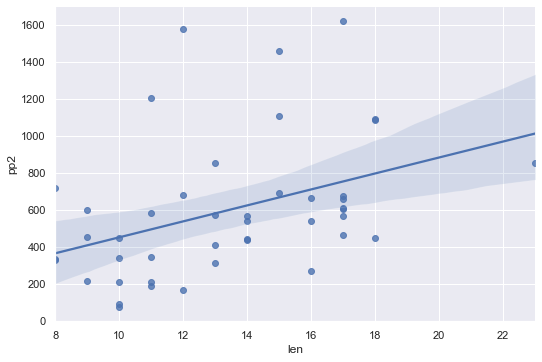

In [62]:
sns.lmplot(data=test.S, x='len', y='pp2', aspect=1.5);

# Generate Text

In [63]:
def generate_text(LM, n=20):
    
    # Start with beginning sentence marker
    words = ['<s>', '<s>']
        
    # Sentence counter
    sent_count = 0
    
    # Generate words stochastically
    while sent_count < n:
        
        # Get trigram context
        bg = tuple(words[-2:])

        # Get next word
        words.append(LM[2].loc[bg].sample(weights='mle2').index.values[0])

        # Terminate when end-of-sentence marker found
        if words[-1] == '</s>':
            sent_count += 1                        
            if sent_count < n:
                words.append('<s>')
    
    # Create text from words
    text = ' '.join(words)
    
    # Format text for printing
    sents = pd.DataFrame(dict(sent_str=text.split('<s> <s>')))
    sents['len'] = sents.sent_str.str.len()
    sents = sents[sents.len > 0]
    sents.sent_str = sents.sent_str.str.replace('<s> ', '')
    sents.sent_str = sents.sent_str.str.replace(' </s>', '')
    sents.sent_str = sents.sent_str.str.strip()
    sents.sent_str = sents.sent_str.str.replace(r" s ", "'s ", regex=True)
    sents['html'] = "<li>" + sents.sent_str.str.upper() + ".</li>"
    output = sents.html.str.cat(sep='\n')
            
    # Print text
    display(HTML(f"<ol style='font-family:monospace;margin-left:1rem;width:4in;'>{output}</ol>"))
    
    # Return sentences with prediction data
    return sents

In [64]:
sents = generate_text(LM, n=20)

# Explore

Compare word usages.

In [65]:
BGM.loc[['anne','wentworth'], ['had','was']]

NameError: name 'BGM' is not defined

# Save

In [ ]:
path_prefix = f"{data_home}/output/austen-combo"
HAPAX.to_csv(f"{path_prefix}-HAPAX.csv")
pd.Series(UNK).to_csv(f"{path_prefix}-UNK.txt", 'w')
for n in range(1, ngram_size):
    NG[n].to_csv(f"{path_prefix}-NG{n}.csv")
    LM[n].to_csv(f"{path_prefix}-LM{n}.csv")

# Fun

How OHCO helps us learn about language. We use the `tokne_num` to explore which words tend to begin and end sentences.

In [ ]:
# All words that begin sentences
VOCAB['start_freq'] = TOKENS.query("token_num == 0").term_str.value_counts()

In [ ]:
# All words that end sentences
VOCAB['end_freq'] = TOKENS.shift(1).query("token_num == 0").term_str.value_counts()

In [ ]:
VOCAB.describe().T

In [ ]:
VOCAB[(VOCAB.start_freq > 5) & (VOCAB.end_freq > 4)].plot.scatter('start_freq','end_freq');

In [ ]:
VOCAB.sort_values('end_freq', ascending=False).head(10)

In [ ]:
VOCAB.sort_values('start_freq', ascending=False).head(10)

In [ ]:
M = TOKENS.value_counts(['token_num','term_str']).unstack(fill_value=0).T

In [ ]:
M[0].sort_values(ascending=False).head(10)

In [ ]:
VOCAB['start_p'] = (VOCAB.start_freq / VOCAB.start_freq.sum())

In [ ]:
VOCAB['end_p'] = (VOCAB.end_freq / VOCAB.end_freq.sum())

In [ ]:
VOCAB.plot.scatter('start_p','end_p');

In [ ]:
VOCAB['start_i'] = -np.log2(VOCAB.start_p)
VOCAB['end_i'] = -np.log2(VOCAB.end_p)

In [ ]:
VOCAB.plot.scatter('start_i','end_i');

In [ ]:
VOCAB.dropna()